## Credit Risk Analysis

<table style="margin-left:0; text-align:left;">
<tr><td><b>Author:</b></td><td>Mahbub Alam</td></tr>
</table>


## Introduction

End-to-end Credit Risk Analysis using the German Credit dataset.

Steps:
- Data quality checks
- Encode target (Risk)
- Exploratory data analysis (EDA): plots for risk vs account status, loan amount, and age
- PD (Probability of Default) modeling with Logistic Regression (using Pipeline, GridSearchCV, and CalibratedClassifierCV)
- LGD (Loss Given Default) simulation + Random Forest model (data lacks recovery)
- EAD (Exposure at Default) simulation (data lacks this column)
- ECL (Expected Credit Loss) calculation
- Visualization of risk segments, summaries by Purpose, Property, and EAD buckets
- Stress testing under adverse scenarios

In [1]:
%matplotlib inline
import numpy as np
np.set_printoptions(precision=3)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import json

## Data quality checks

 Summary:

- Inspect schema and datatypes
- Check for missing values
- Remove duplicates
- Count unique values per column
- Check class balance of the target (Risk: good/bad)

In [2]:
df = pd.read_csv('full_german_credit_dataset.csv')
# print(df.head())

print(f"")
print(df.info())

# Check missing data
missing_data = df.isna().any()
print(f"Missing data? - {'Yes' if missing_data.any() else 'No'}")

# Drop perfect duplicate rows
before = len(df)
df = df.drop_duplicates()
print(f"Duplicates removed: {before - len(df)}")

# check unique values
nunique = df.nunique().to_dict()
print(f"")
print(f"Unique values per column:\n\n{json.dumps(nunique, indent=4)}")

# Zero-variance check
zero_var = np.array([k for k in nunique if nunique[k] <= 1])
print(f"")
print(f"No. of columns with no variability (only one unique value): {len(zero_var)}")

print(f"")
# print(df['Risk'].head())
vc = df['Risk'].value_counts()
vcp = df['Risk'].value_counts(normalize=True)

class_balance = pd.DataFrame({'count' : vc, 'proportion' : vcp})

print(f"")
print(f"Class balance of the target (Risk):\n\n{class_balance}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Status_of_existing_checking_account                       1000 non-null   object
 1   Duration_in_month                                         1000 non-null   int64 
 2   Credit_history                                            1000 non-null   object
 3   Purpose                                                   1000 non-null   object
 4   Credit_amount                                             1000 non-null   int64 
 5   Savings_account_bonds                                     1000 non-null   object
 6   Present_employment_since                                  1000 non-null   object
 7   Installment_rate_in_percentage_of_disposable_income       1000 non-null   int64 
 8   Personal_status_and_sex     

### Encoding Risk

 Encoding target variable Risk into numeric (1=bad, 0=good).
This prepares the dataset for supervised learning models.

In [3]:
df["Risk"] = (df["Risk"] == "bad").astype(int)

## EDA with Account status, Loan amount and Age

 Exploring how credit risk correlates with key features such as:
- Account status (barplot of default rates)
- Loan amount (boxplots by Risk)
- Age (histograms + median lines by Risk)

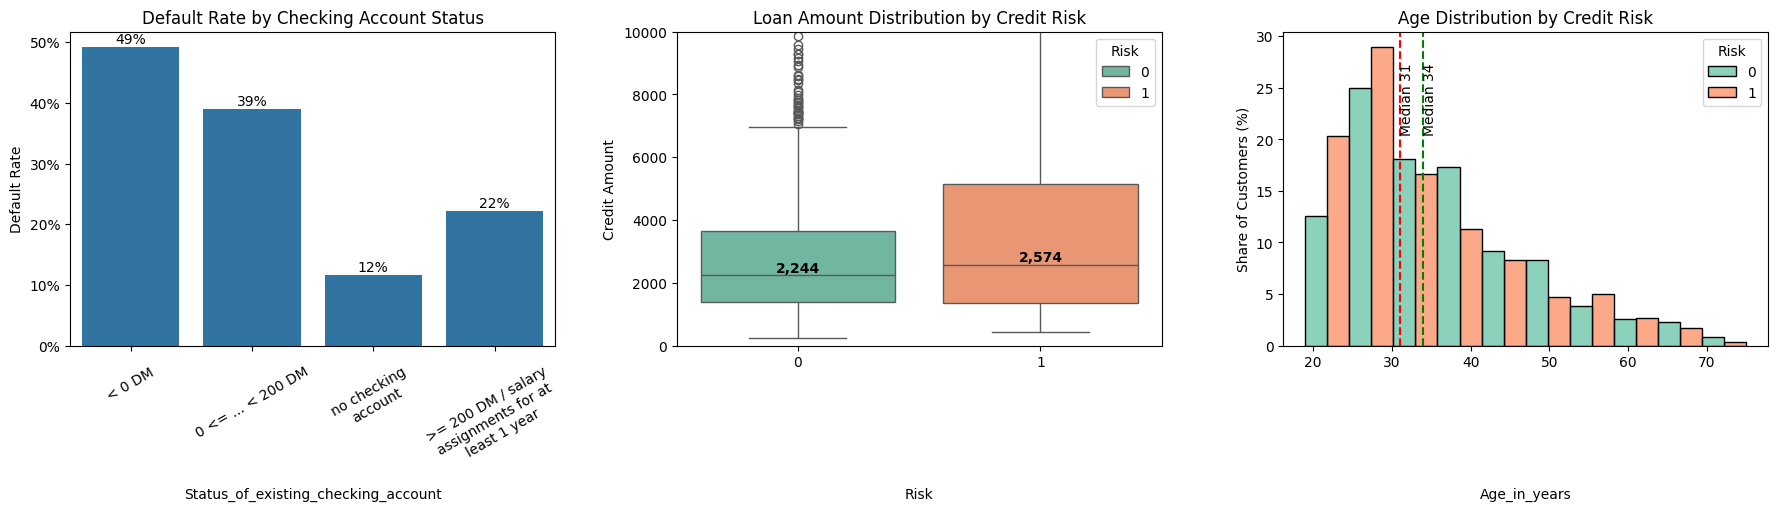

In [4]:
import textwrap

def wrap_labels_(ax, width=15, rotation=0, ha="right", pad=5):# {{{
    """Wrap long labels on x-axis"""
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]

    # Wrap long labels
    wrapped_labels = ["\n".join(textwrap.wrap(l, width=width)) for l in labels]

    # Set ticks + labels explicitly
    ax.set_xticks(ticks)
    if ha == "at_tick":
        ax.set_xticklabels(wrapped_labels, rotation=rotation)
        for label in ax.get_xticklabels():
            label.set_x(label.get_position()[0])
    else:
        ax.set_xticklabels(wrapped_labels, rotation=rotation, ha=ha)

    # Adjust padding
    ax.tick_params(axis="x", pad=pad)


_, axes = plt.subplots(1, 3, figsize=(18, 6), num="risk_vs_acc_status_credit_amount_and_age")
# risk vs account status
ax = sns.barplot(
    x="Status_of_existing_checking_account",
    y="Risk",
    data=df,
    errorbar=None,
    estimator=np.mean,
    ax=axes[0]
)

# adding percentage on top of the bars
for p in ax.patches:
    value = p.get_height()
    ax.annotate(f"{value:.0%}",
                (p.get_x() + p.get_width()/2, value),
                ha="center", va="bottom", fontsize=10)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
wrap_labels_(ax, width=18, rotation=30, ha="at_tick", pad=10)
ax.set_title("Default Rate by Checking Account Status")
ax.set_ylabel("Default Rate")

# risk vs credit amount
ax = sns.boxplot(
    x="Risk",
    y="Credit_amount",
    data=df,
    # showfliers=False,
    hue="Risk",
    dodge=False,
    palette="Set2",
    ax=axes[1]
)

# Add median annotations
medians = df.groupby("Risk")["Credit_amount"].median()
for i, median in enumerate(medians):
    ax.text(i, median, f"{median:,.0f}",
            ha="center", va="bottom", fontsize=10, fontweight="bold", color="black")
ax.set_ylim(0, 10000)
ax.set_title("Loan Amount Distribution by Credit Risk")
ax.set_xlabel("Risk")
ax.set_ylabel("Credit Amount")

# risk vs age
ax = sns.histplot(
    data=df,
    x="Age_in_years",
    hue="Risk",
    bins=10,
    multiple="dodge",
    stat="percent",
    common_norm=False,
    palette="Set2",
    ax=axes[2]
)

# Add median lines for each group
medians = df.groupby("Risk")["Age_in_years"].median()
colors = {0: "green", 1: "red"}

for risk_val, median in medians.items():
    ax.axvline(median, color=colors[risk_val], linestyle="--", linewidth=1.5)
    ax.text(median, ax.get_ylim()[1]*0.9, f"Median {median:.0f}",
            rotation=90, ha="left", va="top", fontsize=10)

ax.set_title("Age Distribution by Credit Risk")
ax.set_xlabel("Age_in_years")
ax.set_ylabel("Share of Customers (%)")

for ax in axes:
    ax.xaxis.set_label_coords(0.5, -0.45)

plt.tight_layout(pad=1.5)
plt.subplots_adjust(wspace=0.25)
plt.savefig('risk_vs_acc_status_credit_amount_and_age.jpg')
plt.show()

## PD model

 This is the Probability of Default (PD) modeling step (Basel/IFRS 9).
- Train Logistic Regression model to predict PD.
- Use preprocessing pipeline with scaling + one-hot encoding.
- Tune hyperparameters via GridSearchCV (refit on ROC-AUC).
- Calibrate final model using isotonic regression to align predicted PDs with observed default rates (CalibratedClassifierCV).

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (roc_auc_score, brier_score_loss,
                             make_scorer, average_precision_score, roc_curve,
                             confusion_matrix, accuracy_score, recall_score)

X = df.drop(columns=['Risk']).copy()
y = df['Risk']

num_features = X.columns[X.dtypes.apply(lambda dt : np.issubdtype(dt, np.number))].tolist()
cat_features = [col for col in X.columns if col not in num_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

pre = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features)
    ])

pd_pipe = Pipeline([
    ("pre", pre),
    ("logreg", LogisticRegression(max_iter = 1000, solver = "liblinear", random_state = 1))
])

hparams = {
    'logreg__C' : np.logspace(-3, 3, 13),
    'logreg__class_weight' : [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 2)

scorers = {
    "roc_auc": "roc_auc",
    "pr_auc": make_scorer(average_precision_score, response_method="predict_proba"),
    "brier": make_scorer(brier_score_loss, response_method="predict_proba", greater_is_better=False)
}

grid = GridSearchCV(
    pd_pipe,
    hparams,
    scoring = scorers,
    cv = cv,
    n_jobs = 4,
    refit = "roc_auc"
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# Calibrate best model using isotonic regression, this ensures PDs align with observed default rates
cal_pd = CalibratedClassifierCV(estimator = best_model, method = "isotonic", cv = 5)
cal_pd.fit(X_train, y_train)

,estimator,Pipeline(step...liblinear'))])
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


### Model report

 Generating validation report for the PD model. Discrimination (ROC-AUC, Gini) and calibration (Brier score) are the primary validation metrics.

- ROC-AUC and Gini coefficient (discrimination power)
- Brier score (calibration quality)
- Average precision score
- KS statistic (max separation between good/bad)

Threshold-based metrics at KS-optimal threshold:
- KS-optimal threshold
- Metrics at that threshold: Accuracy, Recall, Specificity, Confusion matrix

In [6]:
proba_test = cal_pd.predict_proba(X_test)[:,1]
print(f"Test AUC: {roc_auc_score(y_test, proba_test):.3f}")
gini = 2*roc_auc_score(y_test, proba_test) - 1
print(f"Gini coefficient: {gini:.3f}")
print(f"Brier score: {brier_score_loss(y_test, proba_test):.4f}")
print(f"Average precision score: {average_precision_score(y_test, proba_test):.4f}")

fpr, tpr, thresholds = roc_curve(y_test, proba_test)
ks_index = (tpr - fpr).argmax()
ks_stat = tpr[ks_index] - fpr[ks_index]
print(f"KS Statistic: {ks_stat:.3f}")

print(f"")
y_pred_ks = (proba_test >= thresholds[ks_index]).astype(int)
print(f"Optimal KS threshold: {thresholds[ks_index]:.3f}")
print("Diagnostic metrics at KS threshold:")
print(f"    Accuracy: {accuracy_score(y_test, y_pred_ks):.3f}")
print(f"    Recall: {recall_score(y_test, y_pred_ks):.3f}")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_ks).ravel()
specificity = tn / (tn + fp)
print(f"    Specificity (good capture rate): {specificity:.3f}")
print(f"    Confusion Matrix:\n {confusion_matrix(y_test, y_pred_ks)}")

Test AUC: 0.812
Gini coefficient: 0.624
Brier score: 0.1541
Average precision score: 0.6541
KS Statistic: 0.519

Optimal KS threshold: 0.404
Diagnostic metrics at KS threshold:
    Accuracy: 0.790
    Recall: 0.683
    Specificity (good capture rate): 0.836
    Confusion Matrix:
 [[117  23]
 [ 19  41]]


### Save the model for later

 

In [7]:
import joblib

joblib.dump(cal_pd, "pd_model_calibrated.pkl")

# Load model
# cal_pd = joblib.load("pd_model_calibrated.pkl")

['pd_model_calibrated.pkl']

## LGD

 The german credit dataset lacks information on recoveries for defaulted loans,
so Loss Given Default (LGD) cannot be observed directly.
We **simulate LGD using a rule-based approach with random noise**
based on borrowers property, account status, savings, and purpose.

Later we will **train a RandomForest model to estimate LGD from
historical data** (treating part our simulation as historical data).
Predictions are floored at 10% in line with regulatory requirements [CRR Article 164(4)](https://www.eba.europa.eu/single-rule-book-qa/qna/view/publicId/2017_3554).

In [8]:
df_lgd = df.copy()

def lgd_simulation(row):
    # setting base lgd
    lgd = 0.55

    prop = row.get("Property").lower()
    check = row.get("Status_of_existing_checking_account").lower()
    savings = row.get("Savings_account_bonds").lower()
    purpose = row.get("Purpose").lower()

    # Collateral
    if "real estate" in prop or "building" in prop:
        lgd -= 0.20
    elif "car" in prop:
        lgd -= 0.10
    elif "unknown" in prop:
        lgd += 0.05

    # Liquidity buffers
    if ">= 200" in check:
        lgd -= 0.05
    if ">= 1000" in savings or "rich" in savings:
        lgd -= 0.05

    # Purposes that are typically less collateralized
    if purpose in ["education", "retraining", "others"]:
        lgd += 0.05

    return float(np.clip(lgd, 0.05, 0.95))

df_lgd["LGD_prior"] = df_lgd.apply(lgd_simulation, axis=1)

# Adding a randon noise to our simulation
rng = np.random.default_rng(42)
df_lgd["LGD_obs"] = np.where(
    df_lgd["Risk"] == 1,
    np.clip(df_lgd["LGD_prior"] + rng.normal(0, 0.01, size=len(df_lgd)), 0.01, 0.99),
    0.0
)

### Simulate true defaulters

 Summary:
- Sample 90% of bad credits as "true defaulters", using PD-weighted probabilities.
- Assume that only those bad credits truly defaulted.
- Use this as "historical training data" for LGD modeling.

In [9]:
df_lgd["PD"] = cal_pd.predict_proba(X)[:,1]

bad_index = np.where(df_lgd["Risk"] == 1)[0]
weights = df_lgd.loc[bad_index, "PD"].to_numpy()
weights = weights / weights.sum()

rng = np.random.default_rng(43)
true_defaults = rng.choice(bad_index, size=int(0.9 * len(bad_index)), replace=False, p=weights)

df_lgd["true_default"] = 0
df_lgd.loc[true_defaults, "true_default"] = 1

### Random forest model for LGD

 Summary:
- Train Random Forest regressor on simulated LGD data.
- Predict expected LGD (LGD_exp) for entire portfolio.
- Expected LGD predictions are floored at 10% to align with CRR Article 164(4).

In [10]:
from sklearn.ensemble import RandomForestRegressor

X_lgd = df_lgd.loc[true_defaults].drop(columns=["Risk", "PD", "true_default", "LGD_prior", "LGD_obs"]).copy()
y_lgd = df_lgd.loc[true_defaults, "LGD_obs"]
# print(y_lgd.head())

lgd_pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
    ]
)

lgd_model = Pipeline([
    ("pre", lgd_pre),
    ("rf", RandomForestRegressor(n_estimators=300, random_state=40))
])

lgd_model.fit(X_lgd, y_lgd)

df_lgd["LGD_exp"] = np.clip(
    lgd_model.predict(df_lgd.drop(columns=["Risk", "true_default", "LGD_prior", "LGD_obs"])),
    0.10, 0.99
)

## Exposure at Default

 Simulating EAD since the dataset lacks this column.

Formula (Basel/IFRS 9 style):
```
EAD = Balance + CCF * Undrawn

Balance = Amount withdrawn - Amount repaid

CCF = Credit Conversion Factor = Percentage defaulters withdraw just before defaulting
```

In practice, banks use observed balances and limits.
Assumptions:
- Base utilization: random 50–95% of the credit amount
- Risk adjustment: riskier borrowers (high PD) repay less
- CCF fixed at 75% (typical Basel retail assumption)

In [11]:
rng = np.random.default_rng(50)

base_frac = np.clip(rng.normal(0.65, 0.1, size=len(df_lgd)), 0.3, 0.8)

risk_adj = df_lgd["PD"] * 0.2
balance_frac = np.clip(base_frac + risk_adj, 0.5, 0.95)

df_lgd["Withdrawn"] = df_lgd["Credit_amount"] * balance_frac
df_lgd["Undrawn"] = df_lgd["Credit_amount"] - df_lgd["Withdrawn"]

repay_frac = (1 - df_lgd["PD"]) * 0.8
df_lgd["Repaid"] = df_lgd["Withdrawn"] * repay_frac
df_lgd["Balance"] = df_lgd["Withdrawn"] - df_lgd["Repaid"]

CCF = 0.8

df_lgd["EAD"] = df_lgd["Balance"] + CCF * df_lgd["Undrawn"]

## Expected Credit Loss

 This block computes 12-month ECL.
- Formula:
```
ECL = PD * LGD * EAD * discount factor
```
We report portfolio-level stats and segment summaries:
- By Purpose
- By Property * EAD buckets (qcut)

In [12]:
# EIR, one year discount, assumed flat 5% for demonstration
annual_rate = 0.05
discount_factor = 1/(1+annual_rate)

df_lgd["ECL_12m"] = df_lgd["PD"] * df_lgd["LGD_exp"] * df_lgd["EAD"] * discount_factor

print(df_lgd.loc[true_defaults, ["Credit_amount", "PD", "LGD_exp", "EAD", "ECL_12m"]].head())

# Portfolio summaries
print("\n=== Portfolio summary ===")
print("Total EAD:", df_lgd["EAD"].sum().round(2))
print("Total 12m ECL:", df_lgd["ECL_12m"].sum().round(2))
print("Average PD:", df_lgd["PD"].mean().round(3))
print("Average LGD (expected):", df_lgd["LGD_exp"].mean().round(3))
print("ECL / EAD (portfolio charge):", (df_lgd["ECL_12m"].sum() / df_lgd["EAD"].sum()).round(4))

# segment views; purpose and ECL_12m
purpose_ecl = df_lgd.groupby("Purpose")["ECL_12m"].sum()
purpose_ead = df_lgd.groupby("Purpose")["EAD"].sum()
print("\n=== Segment summary (by Purpose) ===")
print(purpose_ecl)
print(f"")
print("ECL density by Purpose:", (purpose_ecl / purpose_ead).round(3))

# Segment views ('Property' and credit size bucket)
EAD_bins = pd.qcut(df_lgd["EAD"], q=4, duplicates="drop")

seg = (
    df_lgd.groupby(["Property", EAD_bins], observed=True).agg(
        n_accounts = ("PD", "size"),
        avg_PD = ("PD", lambda x : round(x.mean(), 3)),
        avg_LGD = ("LGD_exp", lambda x : round(x.mean(), 3)),
        total_EAD = ("EAD", lambda x : round(x.sum(), 2)),
        total_ECL_12m = ("ECL_12m", lambda x : round(x.sum(), 2))
    )
    .reset_index()
    .rename(columns={"EAD": "EAD_bucket"})
)

seg["EAD_bucket"] = seg["EAD_bucket"].apply(
    lambda interval: f"({round(interval.left)}, {round(interval.right)}]"
)
seg["ECL_density"] = (seg["total_ECL_12m"] / seg["total_EAD"]).round(4)

seg.to_csv('segment_view_risk.csv', index=False)

print("\n=== Segment summary (Property x EAD quartiles) ===")
print(seg.head(12))

     Credit_amount        PD   LGD_exp          EAD      ECL_12m
651           1922  0.365605  0.350812  1175.627303   143.603918
35            4746  0.653221  0.358699  3539.794742   789.912268
11            4308  0.909357  0.352324  3893.274429  1187.961084
835           1082  0.669888  0.444590   817.820767   231.969358
601            918  0.398938  0.346274   562.730285    74.034833

=== Portfolio summary ===
Total EAD: 1946229.23
Total 12m ECL: 389244.86
Average PD: 0.302
Average LGD (expected): 0.42
ECL / EAD (portfolio charge): 0.2

=== Segment summary (by Purpose) ===
Purpose
business               62413.548618
car (new)              90711.305545
car (used)             55006.480194
domestic appliances     2476.586166
education              31476.766351
furniture/equipment    61817.990488
others                 28327.749715
radio/TV               48853.533968
repairs                 7755.822860
retraining               405.079536
Name: ECL_12m, dtype: float64

ECL density by Pur

## Visualizing the predictions

 Visualize results with:
- ECL by Purpose (barplot)
- ECL density by EAD bucket
- Total EAD vs Total ECL by Property
- ECL density heatmap (Property * EAD bucket)

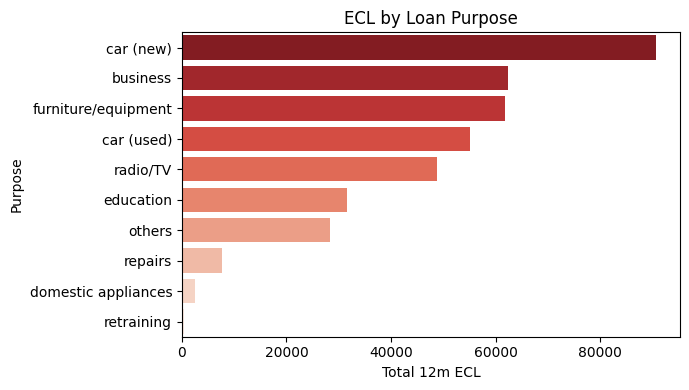

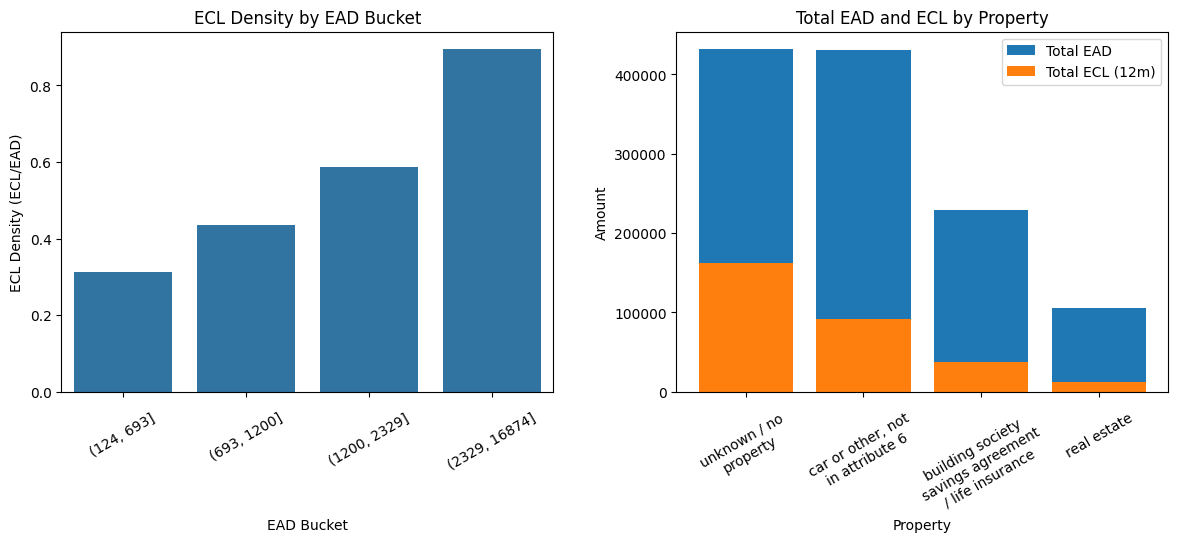

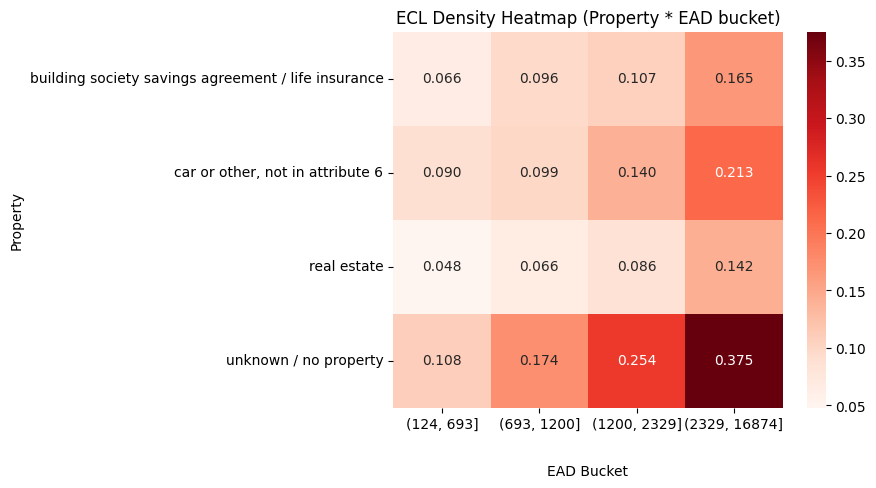

In [13]:
pur_summary = pd.DataFrame(
    purpose_ecl.sort_values(ascending=False).reset_index(),
    columns = np.array(["Purpose", "ECL_12m"])
)

plt.figure(num="ECL by Loan Purpose", figsize=(7,4))
sns.barplot(data=pur_summary, x="ECL_12m", y="Purpose", hue="Purpose", palette="Reds_r")
plt.xlabel("Total 12m ECL")
plt.ylabel("Purpose")
plt.title("ECL by Loan Purpose")
plt.tight_layout()
plt.savefig(f'ECL_by_Loan_Purpose.jpg')
plt.show()

_, axes = plt.subplots(1, 2, figsize=(12, 6), num="risk_vs_acc_status_credit_amount_and_age")
# ECL density by EAD bucket
ax = sns.barplot(
    data=seg,
    x="EAD_bucket",
    y="ECL_density",
    estimator=sum,
    errorbar=None,
    ax=axes[0]
)

wrap_labels_(ax, width=18, rotation=30, ha="at_tick", pad=10)
ax.set_title("ECL Density by EAD Bucket")
ax.set_ylabel("ECL Density (ECL/EAD)")
ax.set_xlabel("EAD Bucket")

# Stacked bar chart total EAD and total ECL by Property
prop_summary = seg.sort_values("total_EAD", ascending=False)

axes[1].bar(prop_summary["Property"], prop_summary["total_EAD"], label="Total EAD")
axes[1].bar(prop_summary["Property"], prop_summary["total_ECL_12m"], label="Total ECL (12m)")
axes[1].set_title("Total EAD and ECL by Property")
axes[1].set_ylabel("Amount")
axes[1].set_xlabel("Property")
wrap_labels_(axes[1], width=18, rotation=30, ha="at_tick", pad=10)
axes[1].legend()

for ax in axes:
    ax.xaxis.set_label_coords(0.5, -0.35)

plt.tight_layout(pad=1.5)
plt.subplots_adjust(wspace=0.25)
plt.savefig('ECL_density_total_EAD_EAD_bucket_Property.jpg')
plt.show()

# ECL density heatmap (Property * EAD bucket)
heatmap_data = seg.pivot_table(index="Property", columns="EAD_bucket",
                               values="ECL_density", aggfunc="mean", observed=True)

plt.figure(num="ECL Density Heatmap (Property * EAD bucket)", figsize=(9,5))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="Reds")
plt.title("ECL Density Heatmap (Property * EAD bucket)")
plt.ylabel("Property")
plt.xlabel("EAD Bucket")
plt.gca().xaxis.set_label_coords(0.5, -0.15)
plt.tight_layout()
plt.savefig(f'ECL_density_heatmap.jpg')
plt.show()

## Stress testing predictions

 Stress-test portfolio under adverse conditions:
- PD +50%
- LGD +20%
- Both combined
- Severe scenario (PD×2, LGD×1.5)

Reporting changes in portfolio ECL vs base case.

In [14]:
# already computed
base_ecl = df_lgd["ECL_12m"].sum().round(2)
print("Base case ECL (12m):", base_ecl)

# stress scenarios
stress_scenarios = {
    "PD +50%": {"PD": 1.5, "LGD": 1.0},
    "LGD +20%": {"PD": 1.0, "LGD": 1.2},
    "PD +50% & LGD +20%": {"PD": 1.5, "LGD": 1.2},
    "Severe stress (PD×2, LGD×1.5)": {"PD": 2.0, "LGD": 1.5}
}

# Apply scenarios
results = {}
for name, factors in stress_scenarios.items():
    df_stress = df_lgd.copy()
    df_stress["PD_stress"] = (df_stress["PD"] * factors["PD"]).clip(upper=1.0)
    df_stress["LGD_stress"] = (df_stress["LGD_exp"] * factors["LGD"]).clip(upper=1.0)
    df_stress["ECL_stress"] = (
        df_stress["PD_stress"] * df_stress["LGD_stress"] * df_stress["EAD"] * discount_factor
    )
    results[name] = df_stress["ECL_stress"].sum().round(2)

# results
print("\nStress Test Results")
for scenario, ecl in results.items():
    print(f"    {scenario:30} : {ecl}  (vs base {base_ecl}, change {((ecl/base_ecl)-1)*100:.1f}%)")

Base case ECL (12m): 389244.86

Stress Test Results
    PD +50%                        : 534839.28  (vs base 389244.86, change 37.4%)
    LGD +20%                       : 467093.84  (vs base 389244.86, change 20.0%)
    PD +50% & LGD +20%             : 641807.13  (vs base 389244.86, change 64.9%)
    Severe stress (PD×2, LGD×1.5)  : 917762.56  (vs base 389244.86, change 135.8%)
